<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/AnalisisDeDatos/3_Agrupacion_y_Agregacion/ejercicio/ejercicio.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>

## Parte A
Para esta parte vamos a trabajar sobre el mismo DataFrame que usamos en clase pero agrupando a nivel de comunidad autónoma (Cod_CCAA). En este caso vamos a traer también las descripciones y vamos a hacer un join para formar un único data set.

In [ ]:
import pandas as pd
import plotly.express as px

In [ ]:
df = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/parodesprov.csv')

In [ ]:
df_descripciones = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/comunidades_descripcion.csv')

Unan ambos DataFrames utilizando la función pd.merge()

In [ ]:
df = df.merge(df_descripciones,left_on='Cod_CCAA',right_on='Código')

Construir el DataFrame de comunidades autónomas, incluyendo la densidad, la proporción de paro y la cantidad de municipios. 

In [ ]:
df_ccaa = df.groupby('Literal').aggregate({'Shape__Area':'sum',
                                       'PAD_1C02':'sum',
                                       'TotalParoRegistrado':'sum',
                                       'Codigo':'size'}).reset_index()

In [ ]:
df_ccaa['Densidad'] = df_ccaa['PAD_1C02'] / df_ccaa['Shape__Area']

In [ ]:
df_ccaa['Proporcion_Paro'] = df_ccaa['TotalParoRegistrado'] / df_ccaa['PAD_1C02']

In [ ]:
df_ccaa.columns

Index(['Literal', 'Shape__Area', 'PAD_1C02', 'TotalParoRegistrado', 'Codigo',
       'Densidad', 'Proporcion_Paro'],
      dtype='object')

In [ ]:
df_ccaa.columns = ['CCAA', 'Area', 'Poblacion', 'TotalParoRegistrado',
       'Cantidad_Municipios', 'Densidad', 'Proporcion_Paro']

Habíamos visto que el promedio de la proporción de paro en los municipios con una densidad menor a la mediana es más bajo.. ¿Se cumple lo mismo para las provincias?

In [ ]:
mediana_densidad = df_ccaa['Densidad'].median()

In [ ]:
df_ccaa.query('Densidad > @mediana_densidad')['Proporcion_Paro'].mean()

0.08842061984034848

In [ ]:
df_ccaa.query('Densidad <= @mediana_densidad')['Proporcion_Paro'].mean()

0.08219794142256939

¿Cuál es la comunidad autónoma con mayor cantidad de municipios?

In [ ]:
df_ccaa.sort_values('Cantidad_Municipios',ascending=False).head(1)

,CCAA,Area,Poblacion,TotalParoRegistrado,Cantidad_Municipios,Densidad,Proporcion_Paro
7,Castilla y León,3.389913e+11,4873320.0,361767.0,4496,0.000014,0.074234


## Parte B
Para esta parte usaremos el siguiente [dataset](https://data.buenosaires.gob.ar/dataset/terrenos-valor-oferta) de Datos Abiertos de CABA, a partir de un relevamiento muestral de los avisos publicados para la venta de departamentos en el año 2020. Se detalla el valor de publicacion, metros cuadrados, antiguedad, cantidad de ambientes, ubicacion, etc.

Importamos los paquetes necesarios y cargamos los datos.

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
df = pd.read_csv("Terrenos-en-venta-2020 (4).csv",encoding = "latin1", sep=",")

In [ ]:
df.head()

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_
0,RIVADAVIA 3500,190,150000,12000000,790,63158,80,CUARTO,ALMAGRO,5
1,PRINGLES 100,242,230000,18400000,950,76033,80,CUARTO,ALMAGRO,5
2,"PERON, JUAN DOMINGO, TTE. 3400",211,265000,21200000,1256,100474,80,CUARTO,ALMAGRO,5
3,MEXICO 4000,320,300000,24000000,938,75000,80,CUARTO,ALMAGRO,5
4,VENEZUELA 4067,250,305000,24400000,1220,97600,80,CUARTO,ALMAGRO,5


In [ ]:
df.shape

(10301, 10)

In [ ]:
df.isnull()

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
10296,False,False,False,False,False,False,False,False,False,False
10297,False,False,False,False,False,False,False,False,False,False
10298,False,False,False,False,False,False,False,False,False,False
10299,False,False,False,False,False,False,False,False,False,False


In [ ]:
df[df.isnull().any(axis=1)]

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_
2256,NaN,323,1600000,102400000,4954,317028,64,SEGUNDO,NUÃEZ,13
2976,NaN,1100,3500000,224000000,3182,203636,64,SEGUNDO,VILLA CRESPO,15
3017,NaN,1050,520000,33280000,495,31695,64,SEGUNDO,VILLA CRESPO,15
3981,NaN,221,420000,26880000,1900,121629,64,SEGUNDO,PARQUE PATRICIOS,4
3985,NaN,128,350000,22400000,2734,175000,64,SEGUNDO,PARQUE PATRICIOS,4
4164,NaN,260,450000,28800000,1731,110769,64,SEGUNDO,VILLA LURO,10


In [ ]:
df.dropna(inplace=True)

In [ ]:
df[df.isnull().any(axis=1)]

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_


### Ejercicio 1. 
¿Cuál es el valor promedio del metro cuadrado en la CABA?

In [ ]:
df.head()

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_
0,RIVADAVIA 3500,190,150000,12000000,790,63158,80,CUARTO,ALMAGRO,5
1,PRINGLES 100,242,230000,18400000,950,76033,80,CUARTO,ALMAGRO,5
2,"PERON, JUAN DOMINGO, TTE. 3400",211,265000,21200000,1256,100474,80,CUARTO,ALMAGRO,5
3,MEXICO 4000,320,300000,24000000,938,75000,80,CUARTO,ALMAGRO,5
4,VENEZUELA 4067,250,305000,24400000,1220,97600,80,CUARTO,ALMAGRO,5


In [ ]:
df.describe()

,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,COMUNA_
count,10295.00000,10295.00000,10295.00000,10295.00000,10295.00000,10295.00000,10295.00000
mean,455.75949,904587.72142,60784664.20583,2357.56824,157850.57261,67.21253,9.25566
std,766.96855,1131244.57397,78249925.68569,1600.37164,107529.32500,4.01777,4.32894
min,30.00000,68000.00000,4352000.00000,355.00000,22705.00000,64.00000,1.00000
25%,200.00000,350000.00000,23520000.00000,1238.00000,83228.00000,64.00000,5.00000
50%,291.00000,580000.00000,38250000.00000,1918.00000,128321.00000,67.00000,10.00000
75%,433.00000,980000.00000,64000000.00000,3019.00000,200836.50000,70.00000,13.00000
max,14303.00000,16000000.00000,1280000000.00000,21429.00000,1714286.00000,80.00000,15.00000


In [ ]:
df["DOLARM2"].mean()

2357.5682370082563

### Ejercicio 2. 
a) Dividir las propiedades por cuartiles de precios en dólares. 

b) ¿Cuáles son los barrios con más domicilios en venta dentro del cuartil más barato de CABA?

In [ ]:
df["Cuartiles"]=pd.qcut(df["PRECIOUSD"],4)

In [ ]:
df["Cuartiles"]

0        (67999.999, 350000.0]
1        (67999.999, 350000.0]
2        (67999.999, 350000.0]
3        (67999.999, 350000.0]
4        (67999.999, 350000.0]
                 ...          
10296     (350000.0, 580000.0]
10297     (580000.0, 980000.0]
10298     (580000.0, 980000.0]
10299     (580000.0, 980000.0]
10300     (350000.0, 580000.0]
Name: Cuartiles, Length: 10295, dtype: category
Categories (4, interval[float64, right]): [(67999.999, 350000.0] < (350000.0, 580000.0] <
                                           (580000.0, 980000.0] < (980000.0, 16000000.0]]

In [ ]:
df.head()

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_,Cuartiles
0,RIVADAVIA 3500,190,150000,12000000,790,63158,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]"
1,PRINGLES 100,242,230000,18400000,950,76033,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]"
2,"PERON, JUAN DOMINGO, TTE. 3400",211,265000,21200000,1256,100474,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]"
3,MEXICO 4000,320,300000,24000000,938,75000,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]"
4,VENEZUELA 4067,250,305000,24400000,1220,97600,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]"


In [ ]:
df["Cuartiles_cat"]=pd.qcut(df["PRECIOUSD"],4,labels=[1,2,3,4])

In [ ]:
df

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_,Cuartiles,Cuartiles_cat
0,RIVADAVIA 3500,190,150000,12000000,790,63158,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1
1,PRINGLES 100,242,230000,18400000,950,76033,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1
2,"PERON, JUAN DOMINGO, TTE. 3400",211,265000,21200000,1256,100474,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1
3,MEXICO 4000,320,300000,24000000,938,75000,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1
4,VENEZUELA 4067,250,305000,24400000,1220,97600,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...
10296,"BONORINO, ESTEBAN, Cnel. 300",149,430000,27412500,2886,183976,64,PRIMER,FLORES NORTE,7,"(350000.0, 580000.0]",2
10297,RIVERA INDARTE 100,500,790000,50362500,1580,100725,64,PRIMER,FLORES NORTE,7,"(580000.0, 980000.0]",3
10298,"ALVAREZ, DONATO, Tte. Gral. 200",771,690000,43987500,895,57052,64,PRIMER,FLORES NORTE,7,"(580000.0, 980000.0]",3
10299,"ALBERDI, JUAN BAUTISTA 3100",409,800000,51000000,1956,124694,64,PRIMER,FLORES NORTE,7,"(580000.0, 980000.0]",3


Usando groupby()

In [ ]:
df.groupby(["BARRIO","Cuartiles_cat"]).count()["Cuartiles"].to_frame().reset_index()

,BARRIO,Cuartiles_cat,Cuartiles
0,AGRONOMIA,1,13
1,AGRONOMIA,2,27
2,AGRONOMIA,3,22
3,AGRONOMIA,4,17
4,ALMAGRO,1,31
...,...,...,...
203,VILLA SOLDATI,4,7
204,VILLA URQUIZA,1,92
205,VILLA URQUIZA,2,145
206,VILLA URQUIZA,3,147


In [ ]:
# Lo guardamos en un nuevo df
df_cuartiles=df.groupby(["BARRIO","Cuartiles_cat"]).count()["Cuartiles"].to_frame().reset_index()

In [ ]:
df_cuartiles.rename(columns={"Cuartiles":"Frecuencia"},inplace=True)

In [ ]:
df_cuartiles[df_cuartiles["Cuartiles_cat"]==1].sort_values(by="Frecuencia", ascending=False)

,BARRIO,Cuartiles_cat,Frecuencia
72,MATADEROS,1,171
108,PARQUE PATRICIOS,1,119
84,NUEVA POMPEYA,1,114
132,SAN CRISTOBAL,1,104
24,BOCA,1,104
68,LINIERS,1,99
96,PARQUE AVELLANEDA,1,97
144,VELEZ SARSFIELD,1,96
204,VILLA URQUIZA,1,92
184,VILLA PUEYRREDON,1,90


In [ ]:
df_cuartiles[df_cuartiles["Cuartiles_cat"]==1].sort_values("Frecuencia", ascending=False).head()

,BARRIO,Cuartiles_cat,Frecuencia
72,MATADEROS,1,171
108,PARQUE PATRICIOS,1,119
84,NUEVA POMPEYA,1,114
132,SAN CRISTOBAL,1,104
24,BOCA,1,104


Usando pivot_table

In [ ]:
dfpivot = df.pivot_table(columns="Cuartiles_cat",index="BARRIO", aggfunc="count")["COMUNA_"].reset_index()

In [ ]:
dfpivot.head()

Cuartiles_cat,BARRIO,1,2,3,4
0,AGRONOMIA,13,27,22,17
1,ALMAGRO,31,79,184,117
2,BALVANERA,77,96,116,140
3,BARRACAS ESTE,69,20,20,49
4,BARRACAS OESTE,3,0,0,3


In [ ]:
dfpivot = dfpivot.rename_axis(None, axis=1)

In [ ]:
dfpivot.head()

,BARRIO,1,2,3,4
0,AGRONOMIA,13,27,22,17
1,ALMAGRO,31,79,184,117
2,BALVANERA,77,96,116,140
3,BARRACAS ESTE,69,20,20,49
4,BARRACAS OESTE,3,0,0,3


Otra forma más sencilla:

In [ ]:
df[df["Cuartiles_cat"]==2]["BARRIO"].value_counts()

VILLA CRESPO          196
VILLA URQUIZA         145
SAAVEDRA              133
BALVANERA              96
MONTE CASTRO           87
SAN CRISTOBAL          85
FLORESTA               80
FLORES NORTE           79
ALMAGRO                79
PARQUE CHAS            76
BOEDO                  76
VILLA LURO             76
CABALLITO              74
VILLA SANTA RITA       71
VILLA DEL PARQUE       67
PALERMO                66
CHACARITA              61
VILLA GRAL. MITRE      59
BOCA                   58
VILLA DEVOTO NORTE     57
MATADEROS              55
VILLA ORTUZAR          54
VELEZ SARSFIELD        52
PARQUE PATRICIOS       51
CONSTITUCION           50
VILLA PUEYRREDON       47
PARQUE CHACABUCO       45
VILLA DEVOTO SUR       42
PATERNAL               38
PARQUE AVELLANEDA      37
NUÃEZ                 37
VERSALLES              34
LINIERS                31
FLORES SUR             28
AGRONOMIA              27
COGHLAN                23
BARRACAS ESTE          20
COLEGIALES             19
NUEVA POMPEY

### 3. ¿Cómo es el precio promedio para cada decil de tamaño?

Probamos calculando el tamaño manualmente y vemos que coincide con la columna PROPIEDADS así que la asociamos a esa variable. 

In [ ]:
df["PRECIOUSD"]/df["DOLARM2"]

0       189.87342
1       242.10526
2       210.98726
3       319.82942
4       250.00000
           ...   
10296   148.99515
10297   500.00000
10298   770.94972
10299   408.99796
10300   279.97738
Length: 10295, dtype: float64

In [ ]:
df['decil']=pd.qcut(df["PROPIEDADS"],10,labels=[i for i in range (0,10)])

In [ ]:
df.head()

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_,Cuartiles,Cuartiles_cat,decil
0,RIVADAVIA 3500,190,150000,12000000,790,63158,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,2
1,PRINGLES 100,242,230000,18400000,950,76033,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,3
2,"PERON, JUAN DOMINGO, TTE. 3400",211,265000,21200000,1256,100474,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,2
3,MEXICO 4000,320,300000,24000000,938,75000,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,5
4,VENEZUELA 4067,250,305000,24400000,1220,97600,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,3


In [ ]:
df.groupby(df['decil'])['PRECIOUSD'].mean().to_frame().reset_index()

,decil,PRECIOUSD
0,1,360674.93411
1,2,431935.33786
2,3,546935.44583
3,4,569111.30242
4,5,652974.35897
5,6,690501.85297
6,7,746102.81359
7,8,897059.64815
8,9,1340582.06900
9,10,2814914.81535


### 4. ¿Cuál es la media de precio por metro cuadrado para cada barrio de la CABA? Ordenar los datos para indicar cuál es el barrio más caro.
Resolverlo tanto con groupby como con pivot_table.

In [ ]:
df.head()

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_,Cuartiles,Cuartiles_cat,decil
0,RIVADAVIA 3500,190,150000,12000000,790,63158,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,2
1,PRINGLES 100,242,230000,18400000,950,76033,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,3
2,"PERON, JUAN DOMINGO, TTE. 3400",211,265000,21200000,1256,100474,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,2
3,MEXICO 4000,320,300000,24000000,938,75000,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,5
4,VENEZUELA 4067,250,305000,24400000,1220,97600,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,3


In [ ]:
df.groupby('BARRIO')['DOLARM2'].mean().sort_values(ascending = False)

BARRIO
RECOLETA             5834.18750
RETIRO               5284.16667
PUERTO MADERO        4906.00000
BELGRANO             4302.16605
PALERMO              4283.04671
NUÃEZ               3778.06701
SAN NICOLAS          3758.36232
COLEGIALES           3398.90090
VILLA CRESPO         3048.57534
COLGIALES            2900.00000
CABALLITO            2868.58937
COGHLAN              2827.58929
VILLA URQUIZA        2775.79184
SAN TELMO            2766.21053
CHACARITA            2679.71713
MONTSERRAT           2641.30208
ALMAGRO              2603.32603
SAAVEDRA             2435.64362
VILLA ORTUZAR        2414.04500
BALVANERA            2353.89977
FLORES NORTE         2315.53767
VILLA DEVOTO NORTE   2139.86207
VILLA DEL PARQUE     2124.63218
BOEDO                1973.63636
AGRONOMIA            1963.05063
VILLA DEVOTO SUR     1943.68831
PARQUE CHAS          1893.88462
VILLA SANTA RITA     1803.85398
VILLA LURO           1754.26887
VILLA PUEYRREDON     1750.33140
PATERNAL             1721.16814
P

In [ ]:
df.head()

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_,Cuartiles,Cuartiles_cat,decil
0,RIVADAVIA 3500,190,150000,12000000,790,63158,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,2
1,PRINGLES 100,242,230000,18400000,950,76033,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,3
2,"PERON, JUAN DOMINGO, TTE. 3400",211,265000,21200000,1256,100474,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,2
3,MEXICO 4000,320,300000,24000000,938,75000,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,5
4,VENEZUELA 4067,250,305000,24400000,1220,97600,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,3


In [ ]:
df.pivot_table(index = 'BARRIO', aggfunc={'DOLARM2':'mean'}).sort_values(by='DOLARM2',ascending=False).reset_index()

,BARRIO,DOLARM2
0,RECOLETA,5834.18750
1,RETIRO,5284.16667
2,PUERTO MADERO,4906.00000
3,BELGRANO,4302.16605
4,PALERMO,4283.04671
5,NUÃEZ,3778.06701
6,SAN NICOLAS,3758.36232
7,COLEGIALES,3398.90090
8,VILLA CRESPO,3048.57534
9,COLGIALES,2900.00000


¿Y si quisieramos ver la dispersión de precios del M2?

In [ ]:
# Considerando la formula del coeficiente de variación
disp = df.groupby('BARRIO')['DOLARM2'].apply(lambda x: x.std() / x.mean()).sort_values(ascending = False)

In [ ]:
disp

BARRIO
BOCA                 0.98326
NUEVA POMPEYA        0.69337
SAN TELMO            0.64843
PARQUE PATRICIOS     0.64539
SAAVEDRA             0.62617
FLORES SUR           0.61620
PARQUE CHACABUCO     0.59972
VILLA LUGANO         0.59116
CHACARITA            0.57820
BALVANERA            0.56948
COGHLAN              0.55486
RETIRO               0.55477
SAN NICOLAS          0.55228
BARRACAS ESTE        0.55036
VILLA LURO           0.54263
VILLA URQUIZA        0.53137
RECOLETA             0.52639
CABALLITO            0.52058
BOEDO                0.51876
VILLA CRESPO         0.50789
COLEGIALES           0.49733
VILLA DEVOTO NORTE   0.49466
PALERMO              0.49451
MONTSERRAT           0.47774
VILLA GRAL. MITRE    0.47720
VILLA ORTUZAR        0.47276
ALMAGRO              0.47082
VILLA DEL PARQUE     0.46869
PATERNAL             0.46811
VILLA SANTA RITA     0.46618
PARQUE AVELLANEDA    0.46170
BELGRANO             0.45840
VILLA PUEYRREDON     0.45834
VILLA DEVOTO SUR     0.45067
VELEZ S

In [ ]:
# Encontramos una fila con un error en el tipeo de Colegiales.
df["BARRIO"]=df["BARRIO"].replace("COLGIALES","COLEGIALES")

In [ ]:
# Volvemos a crear la variable disp una vez hechos los cambios
disp = df.groupby('BARRIO')['DOLARM2'].apply(lambda x: x.std() / x.mean()).sort_values(ascending = False)

In [ ]:
disp

BARRIO
BOCA                 0.98326
NUEVA POMPEYA        0.69337
SAN TELMO            0.64843
PARQUE PATRICIOS     0.64539
SAAVEDRA             0.62617
FLORES SUR           0.61620
PARQUE CHACABUCO     0.59972
VILLA LUGANO         0.59116
CHACARITA            0.57820
BALVANERA            0.56948
COGHLAN              0.55486
RETIRO               0.55477
SAN NICOLAS          0.55228
BARRACAS ESTE        0.55036
VILLA LURO           0.54263
VILLA URQUIZA        0.53137
RECOLETA             0.52639
CABALLITO            0.52058
BOEDO                0.51876
VILLA CRESPO         0.50789
COLEGIALES           0.49593
VILLA DEVOTO NORTE   0.49466
PALERMO              0.49451
MONTSERRAT           0.47774
VILLA GRAL. MITRE    0.47720
VILLA ORTUZAR        0.47276
ALMAGRO              0.47082
VILLA DEL PARQUE     0.46869
PATERNAL             0.46811
VILLA SANTA RITA     0.46618
PARQUE AVELLANEDA    0.46170
BELGRANO             0.45840
VILLA PUEYRREDON     0.45834
VILLA DEVOTO SUR     0.45067
VELEZ S

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 145 missing from current font.
  font.set_text(s, 0, flags=flags)


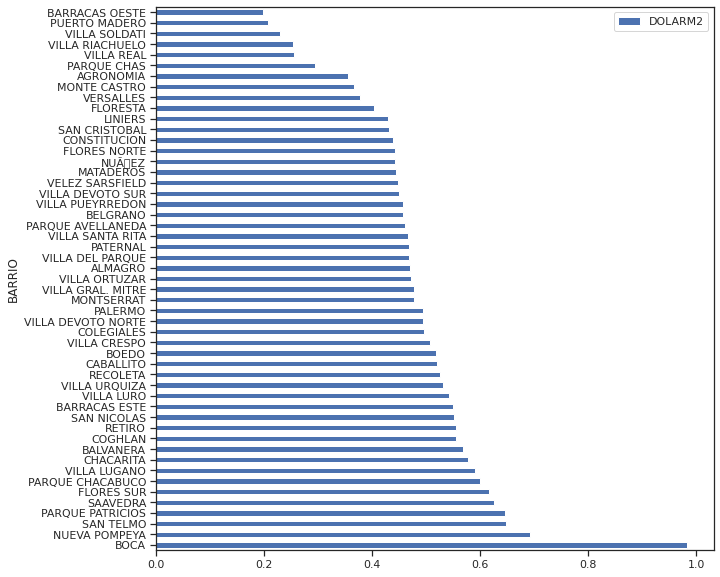

In [ ]:
disp.to_frame().plot(kind='barh',figsize=(10,10))

### 5. Dada la siguiente [fuente](https://data.buenosaires.gob.ar/dataset/terrenos-valor-oferta/resource/c9a6fed8-da1d-460e-92a8-e0213d68f59c ) con similar información pero de 2019: 
### ¿Qué porcentaje de propiedades que estaban en venta durante 2019 siguieron estando en 2020?

In [ ]:
df19 = pd.read_csv("Terrenos-en-venta-2019 (2).csv",encoding="latin1", sep=",")

In [ ]:
df19.shape

(5006, 13)

In [ ]:
df19.head()

,OPERACION,TIPO,LATITUD,LONGITUD,M2TOTAL,DIRECCION,CAMBIO,PRECIOUSD,PRECIOARS,PRECIOUSDM,PRECIOARSM,BARRIOS,COMUNA
0,VTA,TERRENO,-34.6294378,-58.4498948,235.00000,Malvinas Argentinas al 400,45.00,1100000.00000,49500000,4681.00000,210645.00000,CABALLITO,6
1,VTA,TERRENO,-34.6289663,-58.4483573,1629.00000,Jose Bonifacio 1520,45.00,1400000.00000,63000000,859.00000,38655.00000,CABALLITO,6
2,VTA,TERRENO,-34.6265344,-58.4326234,438.00000,BONIFACIO JOSE 400,45.00,2380000.00000,107100000,1062.00000,47790.00000,CABALLITO,6
3,VTA,TERRENO,-34.6248406,-58.4317985,272.00000,VIEL al 600,45.00,895000.00000,40275000,3290.00000,148050.00000,CABALLITO,6
4,VTA,TERRENO,-34.622629,-58.44079,600.00000,Av. Del Barco Centenera 200,45.00,400000.00000,18000000,667.00000,30015.00000,CABALLITO,6


In [ ]:
df.shape

(10295, 13)

In [ ]:
# Dado que nuestro único código unificador es la dirección, buscamos la manera de unificar la forma de unificar ambas columnas entre ambos Dataframes.  
df19["DIRECCION"]=df19["DIRECCION"].str.replace("al ","")

In [ ]:
df.head()

,DIRECCION,PROPIEDADS,PRECIOUSD,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_,Cuartiles,Cuartiles_cat,decil
0,RIVADAVIA 3500,190,150000,12000000,790,63158,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,2
1,PRINGLES 100,242,230000,18400000,950,76033,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,3
2,"PERON, JUAN DOMINGO, TTE. 3400",211,265000,21200000,1256,100474,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,2
3,MEXICO 4000,320,300000,24000000,938,75000,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,5
4,VENEZUELA 4067,250,305000,24400000,1220,97600,80,CUARTO,ALMAGRO,5,"(67999.999, 350000.0]",1,3


In [ ]:
df19.head()

,OPERACION,TIPO,LATITUD,LONGITUD,M2TOTAL,DIRECCION,CAMBIO,PRECIOUSD,PRECIOARS,PRECIOUSDM,PRECIOARSM,BARRIOS,COMUNA
0,VTA,TERRENO,-34.6294378,-58.4498948,235.00000,Malvinas Argentinas 400,45.00,1100000.00000,49500000,4681.00000,210645.00000,CABALLITO,6
1,VTA,TERRENO,-34.6289663,-58.4483573,1629.00000,Jose Bonifacio 1520,45.00,1400000.00000,63000000,859.00000,38655.00000,CABALLITO,6
2,VTA,TERRENO,-34.6265344,-58.4326234,438.00000,BONIFACIO JOSE 400,45.00,2380000.00000,107100000,1062.00000,47790.00000,CABALLITO,6
3,VTA,TERRENO,-34.6248406,-58.4317985,272.00000,VIEL 600,45.00,895000.00000,40275000,3290.00000,148050.00000,CABALLITO,6
4,VTA,TERRENO,-34.622629,-58.44079,600.00000,Av. Del Barco Centenera 200,45.00,400000.00000,18000000,667.00000,30015.00000,CABALLITO,6


In [ ]:
# Probamos un primer inner join.
df.merge(df19,how="inner", left_on="DIRECCION",right_on="DIRECCION")

,DIRECCION,PROPIEDADS,PRECIOUSD_x,PRECIOPESO,DOLARM2,PESOSM2,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_,...,LATITUD,LONGITUD,M2TOTAL,CAMBIO,PRECIOUSD_y,PRECIOARS,PRECIOUSDM,PRECIOARSM,BARRIOS,COMUNA
0,QUERANDIES 4200,234,450000,36000000,1923,153846,80,CUARTO,ALMAGRO,5,...,-34.61105,-58.42643,234.00000,45.00,450000.00000,#VALUE!,1923.00000,86535.00000,ALMAGRO,5
1,QUERANDIES 4200,234,450000,36000000,1923,153846,80,CUARTO,ALMAGRO,5,...,-34.61105,-58.42643,234.00000,"43,2",450000.00000,19440000,1923.07692,83074.00000,ALMAGRO,5
2,QUERANDIES 4200,234,450000,36000000,1923,153846,80,CUARTO,ALMAGRO,5,...,-34.61105,-58.42643,234.00000,41.40,410000.00000,16974000,1752.13675,72533.00000,ALMAGRO,5
3,QUERANDIES 4200,234,450000,36000000,1923,153846,80,CUARTO,ALMAGRO,5,...,-34.61105,-58.42643,234.00000,41.40,450000.00000,18630000,1923.07692,79612.00000,ALMAGRO,5
4,QUERANDIES 4200,234,450000,36000000,1923,153846,80,CUARTO,ALMAGRO,5,...,-34.61105,-58.42643,234.00000,38.40,410000.00000,15744000,1752.00000,67277.00000,ALMAGRO,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,SAN BLAS 4900,460,543000,34616250,1180,75253,64,TERCER,VELEZ SARSFIELD,10,...,-3462675,-585046,373.00000,51.80,520000.00000,26936000,1394.10188,72209.00000,VELEZ SARSFIELD,10
1873,SAN BLAS 4900,460,543000,34616250,1180,75253,64,TERCER,VELEZ SARSFIELD,10,...,"-34,62675","-58,5046",373.00000,"56,16",520000.00000,29203200,1394.00000,78287.00000,VELEZ SARSFIELD,10
1874,SAN BLAS 4900,460,543000,34616250,1180,75253,64,TERCER,VELEZ SARSFIELD,10,...,-3462675,-585046,373.00000,58.90,520000.00000,30628000,1394.10188,80857.90887,VELEZ SARSFIELD,10
1875,SAN BLAS 4900,460,543000,34616250,1180,75253,64,TERCER,VELEZ SARSFIELD,10,...,-3462675,-585046,373.00000,60.38,520000.00000,31397600,1394.00000,84170.00000,VELEZ SARSFIELD,10


Encontramos 1877 propiedades en común. Busquemos formas de mejorar esto.

In [ ]:
# Podríamos dropear duplicados dentro de un Dataframe usando drop_duplicates. Subset nos determina qué columna/s vamos a mirar como criterio de fila duplicada.
df = df.drop_duplicates(subset="DIRECCION")
df19 = df19.drop_duplicates(subset= "DIRECCION")

Pasamos todo a lowercase para ver si matcheamos más propiedades:

In [ ]:
df["DIRECCION"]=df["DIRECCION"].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df19["DIRECCION"]=df19["DIRECCION"].str.lower()

In [ ]:
df.columns

Index(['DIRECCION', 'PROPIEDADS', 'PRECIOUSD', 'PRECIOPESO', 'DOLARM2',
       'PESOSM2', 'COTIZACION', 'TRIMESTRE_', 'BARRIO', 'COMUNA_', 'Cuartiles',
       'Cuartiles_cat', 'decil'],
      dtype='object')

In [ ]:
df19.columns

Index(['OPERACION', 'TIPO', 'LATITUD', 'LONGITUD', 'M2TOTAL', 'DIRECCION',
       'CAMBIO', 'PRECIOUSD', 'PRECIOARS', 'PRECIOUSDM', 'PRECIOARSM',
       'BARRIOS', 'COMUNA'],
      dtype='object')

In [ ]:
df_merge = df.merge(df19,how="inner", left_on="DIRECCION",right_on="DIRECCION")

In [ ]:
df_merge.shape

(777, 25)

In [ ]:
777/5006

0.15521374350779066